In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
from skimage.color import rgb2hed
import skimage.io as io
import numpy as np
import pandas as pd
from PIL import Image
from skimage import measure
from skimage.measure import regionprops
from tqdm import tqdm

def mean_dab_value(image_path):
    try:
        # Load the image
        image = io.imread(image_path)
    except Exception as e:
        print(f"Error processing DAB for file {image_path}: {e}")
        return None  # Or handle it appropriately
    
    # Convert the image from RGB to HED color space
    hed_image = rgb2hed(image)
    
    # Extract the DAB channel (third channel in HED)
    dab_channel = hed_image[:, :, 2]
    
    # Compute the mean DAB value
    mean_dab = np.mean(dab_channel)
    
    return mean_dab

def binary_to_instance(mask_path):
    try:
        # Load the mask image
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        mask_array = np.array(mask)
    except Exception as e:
        print(f"Error processing SHAPES for file {mask_path}: {e}")
        return None, None  # Or handle it appropriately
    
    # Binarize the mask (ensure binary values: 0 and 1)
    binary_mask = np.where(mask_array > 0, 1, 0).astype(np.uint8)
    
    # Label connected components
    labeled_mask = measure.label(binary_mask)

def calculate_shape_properties(inst_mask):
    
    # Get properties of labeled regions
    properties = regionprops(inst_mask)
    
    if not properties:
        print("No shapes found in the mask.")
        mean_properties = {
            'area_weighted_solidity': 1,
            'total_area': 0,
            # 'area': [prop.area for prop in properties],
            'med_area': 0,
        }

        return mean_properties

        # return None
    
    # Initialize sums for each property
    sum_solidity = 0
    sum_area = 0
    
    # num_shapes = len(properties)

    # for prop in properties:
    #     print(prop, properties[prop])

    
    # Accumulate values for each property
    for prop in properties:
        sum_solidity += prop.solidity * prop.area
        sum_area += prop.area
    
    # Calculate mean values for each property
    mean_properties = {
        'area_weighted_solidity': sum_solidity / sum_area,
        'total_area': sum_area,
        # 'area': [prop.area for prop in properties],
        'med_area': np.median([prop.area for prop in properties]),
    }
    
    return mean_properties


In [2]:
import glob, os, sys
sys.path.append('/workspace/stardist')
from utils.utils import *


sdm_pardir = "/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6"
sdm_dirs = sorted(glob.glob(os.path.join(sdm_pardir, "*")))

# sdm_dirs = [x for x in sdm_dirs if 'output_train_shuffle_model' in x]

sdm_dirs = {os.path.split(k)[-1] : k for k in sdm_dirs}
print(sdm_dirs)

# sdm_dirs.pop("output_shuffle_model_s1.5_040000")
# sdm_dirs.pop("output_clus4_shuffle_model_s1.5_040000")

sdm_file_list, sdm_label = get_file_label(sdm_dirs, img_path='samples', inst_path='inst_masks')
sdm_app_list, sdm_app_label = get_file_label(sdm_dirs, img_path='images', inst_path='app_inst_masks')

print("sdm_files -> ", len(sdm_file_list))
print("sdm_app -> ", len(sdm_app_list))

{'v1.1_output_model_s1.2_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.2_040000', 'v1.1_output_model_s1.2_050000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.2_050000', 'v1.1_output_model_s1.4_030000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_030000', 'v1.1_output_model_s1.4_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_040000', 'v1.1_output_model_s1.4_050000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.4_050000', 'v1.1_output_model_s1.5_030000': '/mnt/dataset/MoNuSeg/out_sdm/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6/v1.1_output_model_s1.5_030000', 'v1.1_output_model_s1.5_040000': '/mnt/dataset/MoNuSeg/out_sdm/patches_vali

In [3]:
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes
from tqdm.notebook import tqdm

def get_xy_from_file_list(file_list):

    n_channel = 3
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
        sys.stdout.flush()

    img_preprocess = lambda x : normalize(x,1,99.8,axis=axis_norm)
    label_preprocess = lambda x : fill_label_holes(x)

    x_id = 0
    y_id = 2
    mask_dtype = 'I'

    images = list(map(lambda x: read_img(x[x_id], 'RGB'), tqdm(file_list)))
    X = list(map(lambda x: img_preprocess(read_img(x[x_id], 'RGB')), tqdm(file_list)))
    Y = list(map(lambda x: label_preprocess(read_img(x[y_id], mask_dtype)), tqdm(file_list)))

    return X, Y, images



In [4]:
X_sdm, Y_sdm, I_smd = get_xy_from_file_list(sdm_file_list)
X_app, Y_app, I_app = get_xy_from_file_list(sdm_app_list)


Normalizing image channels independently.


  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

Normalizing image channels independently.


  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

In [5]:
import time

show = False

if show:
    for y in Y_app:
        print(np.unique(y))
        plt.imshow(y, cmap=lbl_cmap)
        plt.show()
        time.sleep(5)

In [6]:
Y_sdm_prop = [calculate_shape_properties(y) for y in tqdm(Y_sdm)]

  0%|          | 0/1144 [00:00<?, ?it/s]

No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.


In [7]:
Y_app_prop = [calculate_shape_properties(y) for y in tqdm(Y_app)]

  0%|          | 0/1144 [00:00<?, ?it/s]

No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.
No shapes found in the mask.


In [8]:
assert len(Y_app_prop) == len(Y_sdm_prop)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


keys = Y_sdm_prop[0].keys()
print(keys)

df_sdm_prop = {k:[x[k] for x in Y_sdm_prop] for k in keys}
df_sdm_prop = {k:np.array(v) for k, v in df_sdm_prop.items()}
df_sdm_prop = pd.DataFrame.from_dict(df_sdm_prop)


# df_sdm_prop = {
#     'med' : [x[0] if x is not None else 1 for x in Y_sdm_prop],
#     'area' : [x[1] if x is not None else 0 for x in Y_sdm_prop],
# }
# df_sdm_prop = {k:np.array(v) for k, v in df_sdm_prop.items()}
# df_sdm_prop = pd.DataFrame.from_dict(df_sdm_prop)

# df_app_prop = {
#     'med' : [x[0] if x is not None else 1 for x in Y_app_prop],
#     'area' : [x[1] if x is not None else 0 for x in Y_app_prop],
# }
# df_app_prop = {k:np.array(v) for k, v in df_app_prop.items()}
# df_app_prop = pd.DataFrame.from_dict(df_app_prop)

df_app_prop = {k:[x[k] for x in Y_app_prop] for k in keys}
df_app_prop = {k:np.array(v) for k, v in df_app_prop.items()}
df_app_prop = pd.DataFrame.from_dict(df_app_prop)





dict_keys(['area_weighted_solidity', 'total_area', 'med_area'])


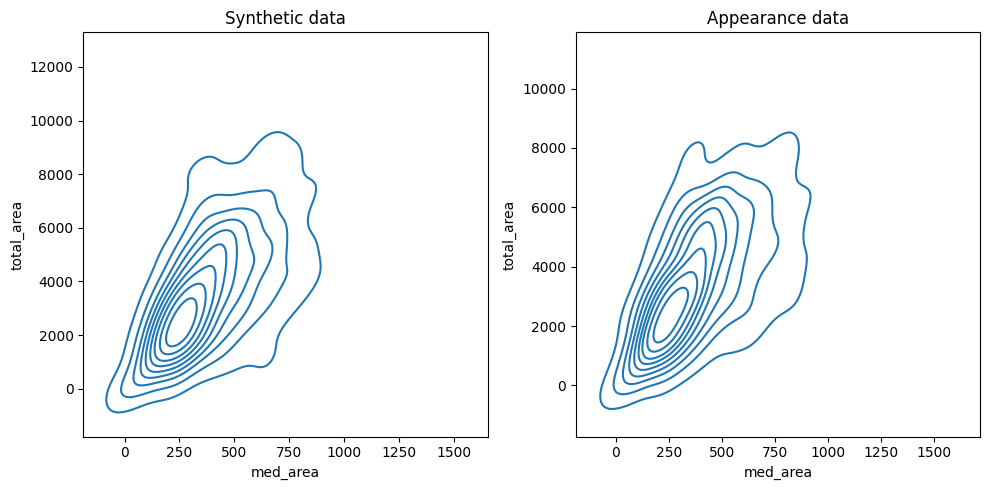

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(data=df_sdm_prop, x="med_area", y="total_area", ax=ax[0])
sns.kdeplot(data=df_app_prop, x="med_area", y="total_area", ax=ax[1])
ax[0].set_title("Synthetic data")
ax[1].set_title("Appearance data")

fig.tight_layout()
plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = None

if scaler:

    data = np.array(df_sdm_prop['area']).reshape(-1, 1)
    scaler.fit(data)
    df_sdm_prop['area'] = scaler.transform(data)

    data = np.array(df_app_prop['area']).reshape(-1, 1)
    scaler.fit(data)
    df_app_prop['area'] = scaler.transform(data)


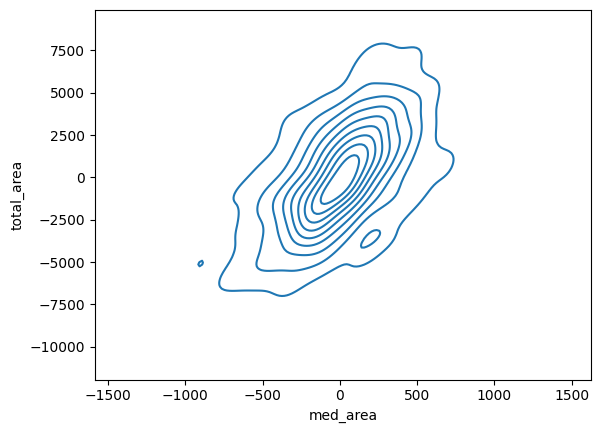

In [28]:
df_diff = {
    k : df_sdm_prop[k] - df_app_prop[k] for k in df_sdm_prop.keys()
}
df_diff = pd.DataFrame.from_dict(df_diff)

sns.kdeplot(data=df_diff, x="med_area", y="total_area")
plt.show()

Index(['area_weighted_solidity', 'total_area', 'med_area'], dtype='object')
area_weighted_solidity    0.00013
total_area                1.00000
med_area                  0.50000
dtype: float64 area_weighted_solidity       0.039775
total_area                3788.750000
med_area                   368.275000
dtype: float64
area_weighted_solidity    0.0
total_area                0.0
med_area                  0.0
dtype: float64 area_weighted_solidity    1.0
total_area                1.0
med_area                  1.0
dtype: float64


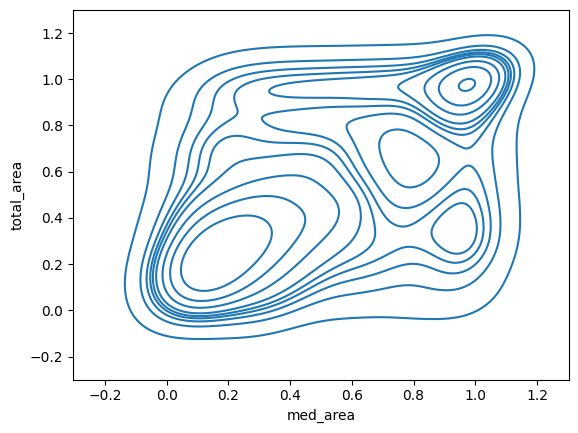

In [29]:
print(df_diff.keys())

df_diff_scaled = df_diff.abs()
df_diff_scaled = df_diff_scaled.clip(upper=df_diff_scaled.quantile(.85), axis=1)

print(df_diff_scaled.min(), df_diff_scaled.max())

scaler = MinMaxScaler()
df_diff_scaled = pd.DataFrame(scaler.fit_transform(df_diff_scaled), columns=df_diff_scaled.keys())

print(df_diff_scaled.min(), df_diff_scaled.max())

sns.kdeplot(data=df_diff_scaled, x="med_area", y="total_area")
plt.show()

In [30]:
print(df_diff)

print(df_diff_scaled)

      area_weighted_solidity  total_area  med_area
0                  -0.023624       934.0      97.0
1                  -0.020213      1894.0      26.0
2                   0.060710      5579.0     617.5
3                  -0.002891      3122.0    1263.5
4                   0.000130       223.0     -68.0
...                      ...         ...       ...
1139                0.015676     -4597.0     -45.0
1140               -0.007541       827.0     194.5
1141                0.037157       826.0     528.5
1142                0.060518     -1089.0    -500.0
1143                0.017863     -2055.0     364.0

[1144 rows x 3 columns]
      area_weighted_solidity  total_area  med_area
0                   0.592611    0.246320  0.262389
1                   0.506577    0.499769  0.069336
2                   1.000000    1.000000  1.000000
3                   0.069646    0.823972  1.000000
4                   0.000000    0.058610  0.183536
...                      ...         ...       ...
1139  

In [31]:
df_diff_scaled['score'] = df_diff_scaled['med_area'] * .5 + df_diff_scaled['total_area'] * .5
df_diff_scaled['prob'] = 1- df_diff_scaled['score'].clip(0, 1)

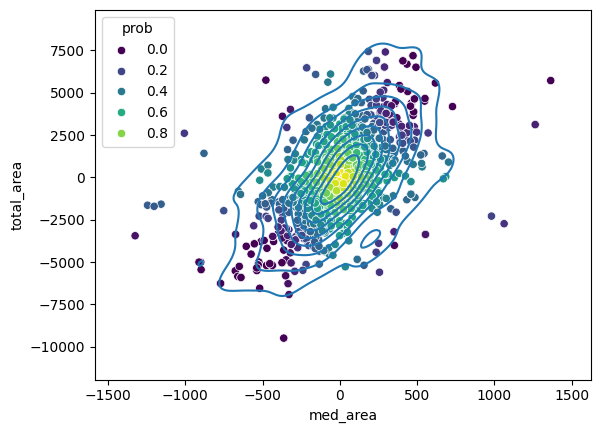

In [32]:
df_diff['prob'] = df_diff_scaled['prob']

sns.kdeplot(data=df_diff, x="med_area", y="total_area")
ax = plt.gca()
sns.scatterplot(data=df_diff, x="med_area", y="total_area", hue='prob', palette='viridis', ax=ax)

plt.show()


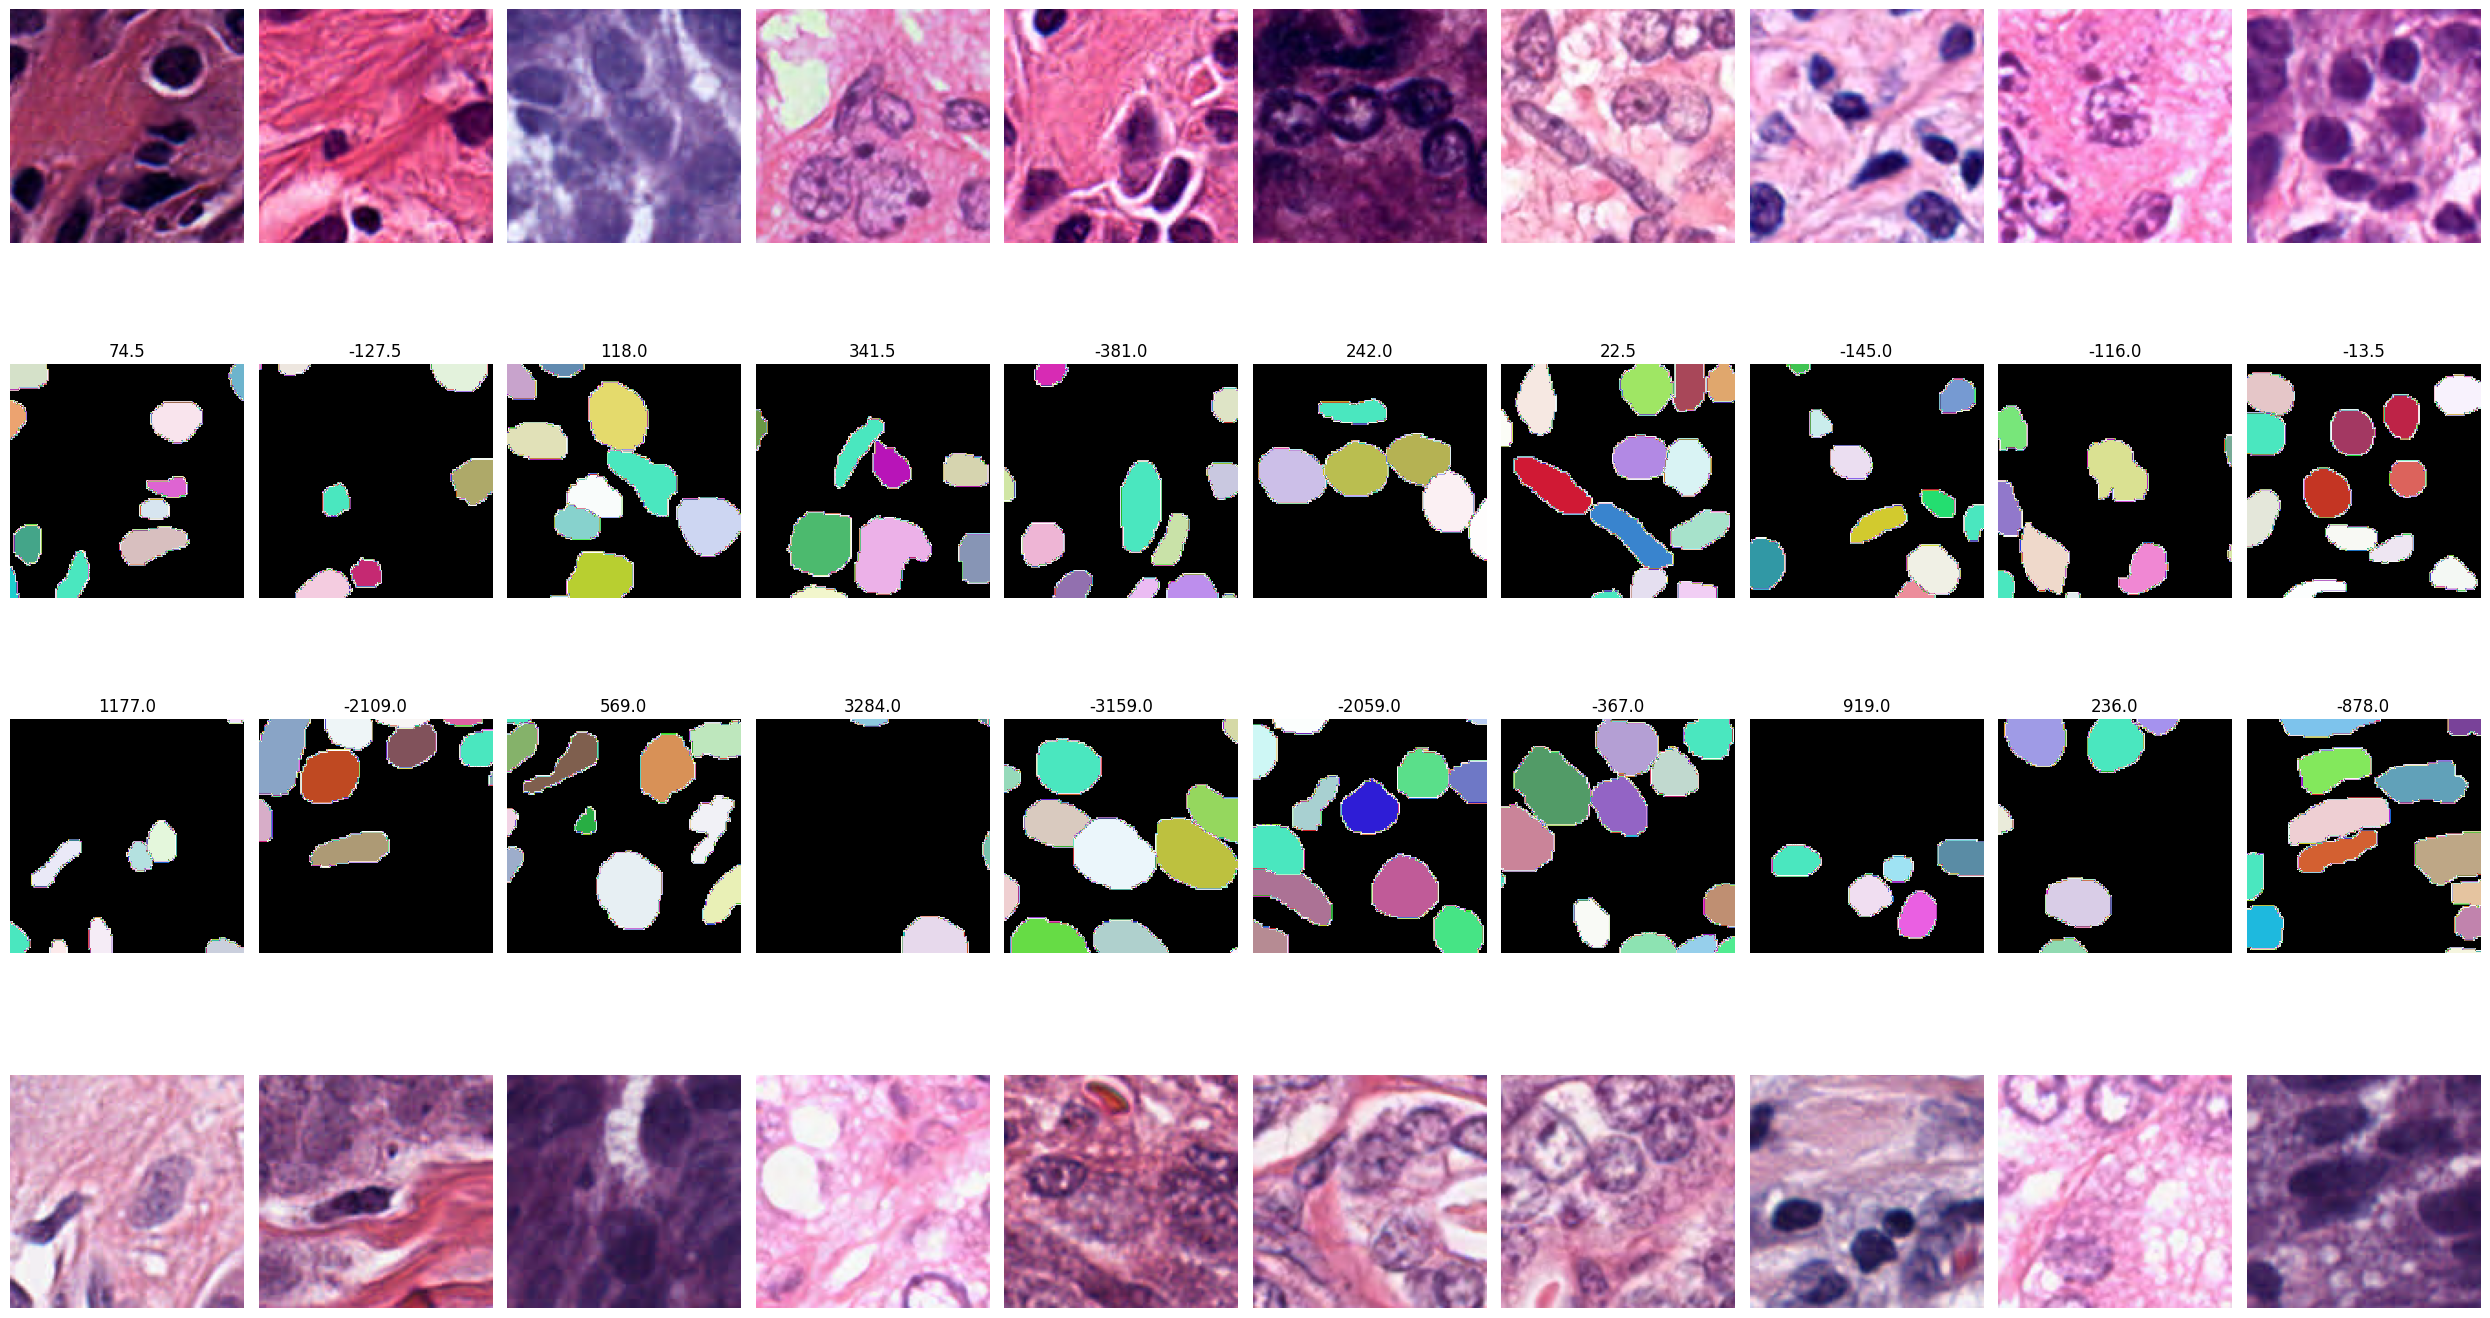

In [42]:
from matplotlib import pyplot as plt
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(42)
lbl_cmap = random_label_cmap()

n_img = 10
fig, ax = plt.subplots(4, n_img, figsize=(25, 15))

ind = np.random.choice(len(I_smd), n_img, replace=False)

for i in range(n_img):
    y = ind[i]
    img = I_smd[y]
    ann = Y_sdm[y]
    pred = Y_app[y]
    app = I_app[y]
    # f1 = getattr(stats_sdm_best[y], 'f1')


    ax[0, i].imshow(img)
    ax[1, i].set_title(df_diff['med'][y])
    ax[1, i].imshow(ann, cmap=lbl_cmap)
    ax[2, i].set_title(df_diff['area'][y])
    ax[2, i].imshow(pred, cmap=lbl_cmap)
    ax[3, i].imshow(app)

    [axs.axis("off") for axs in ax.flatten()]

fig.tight_layout()

plt.show()

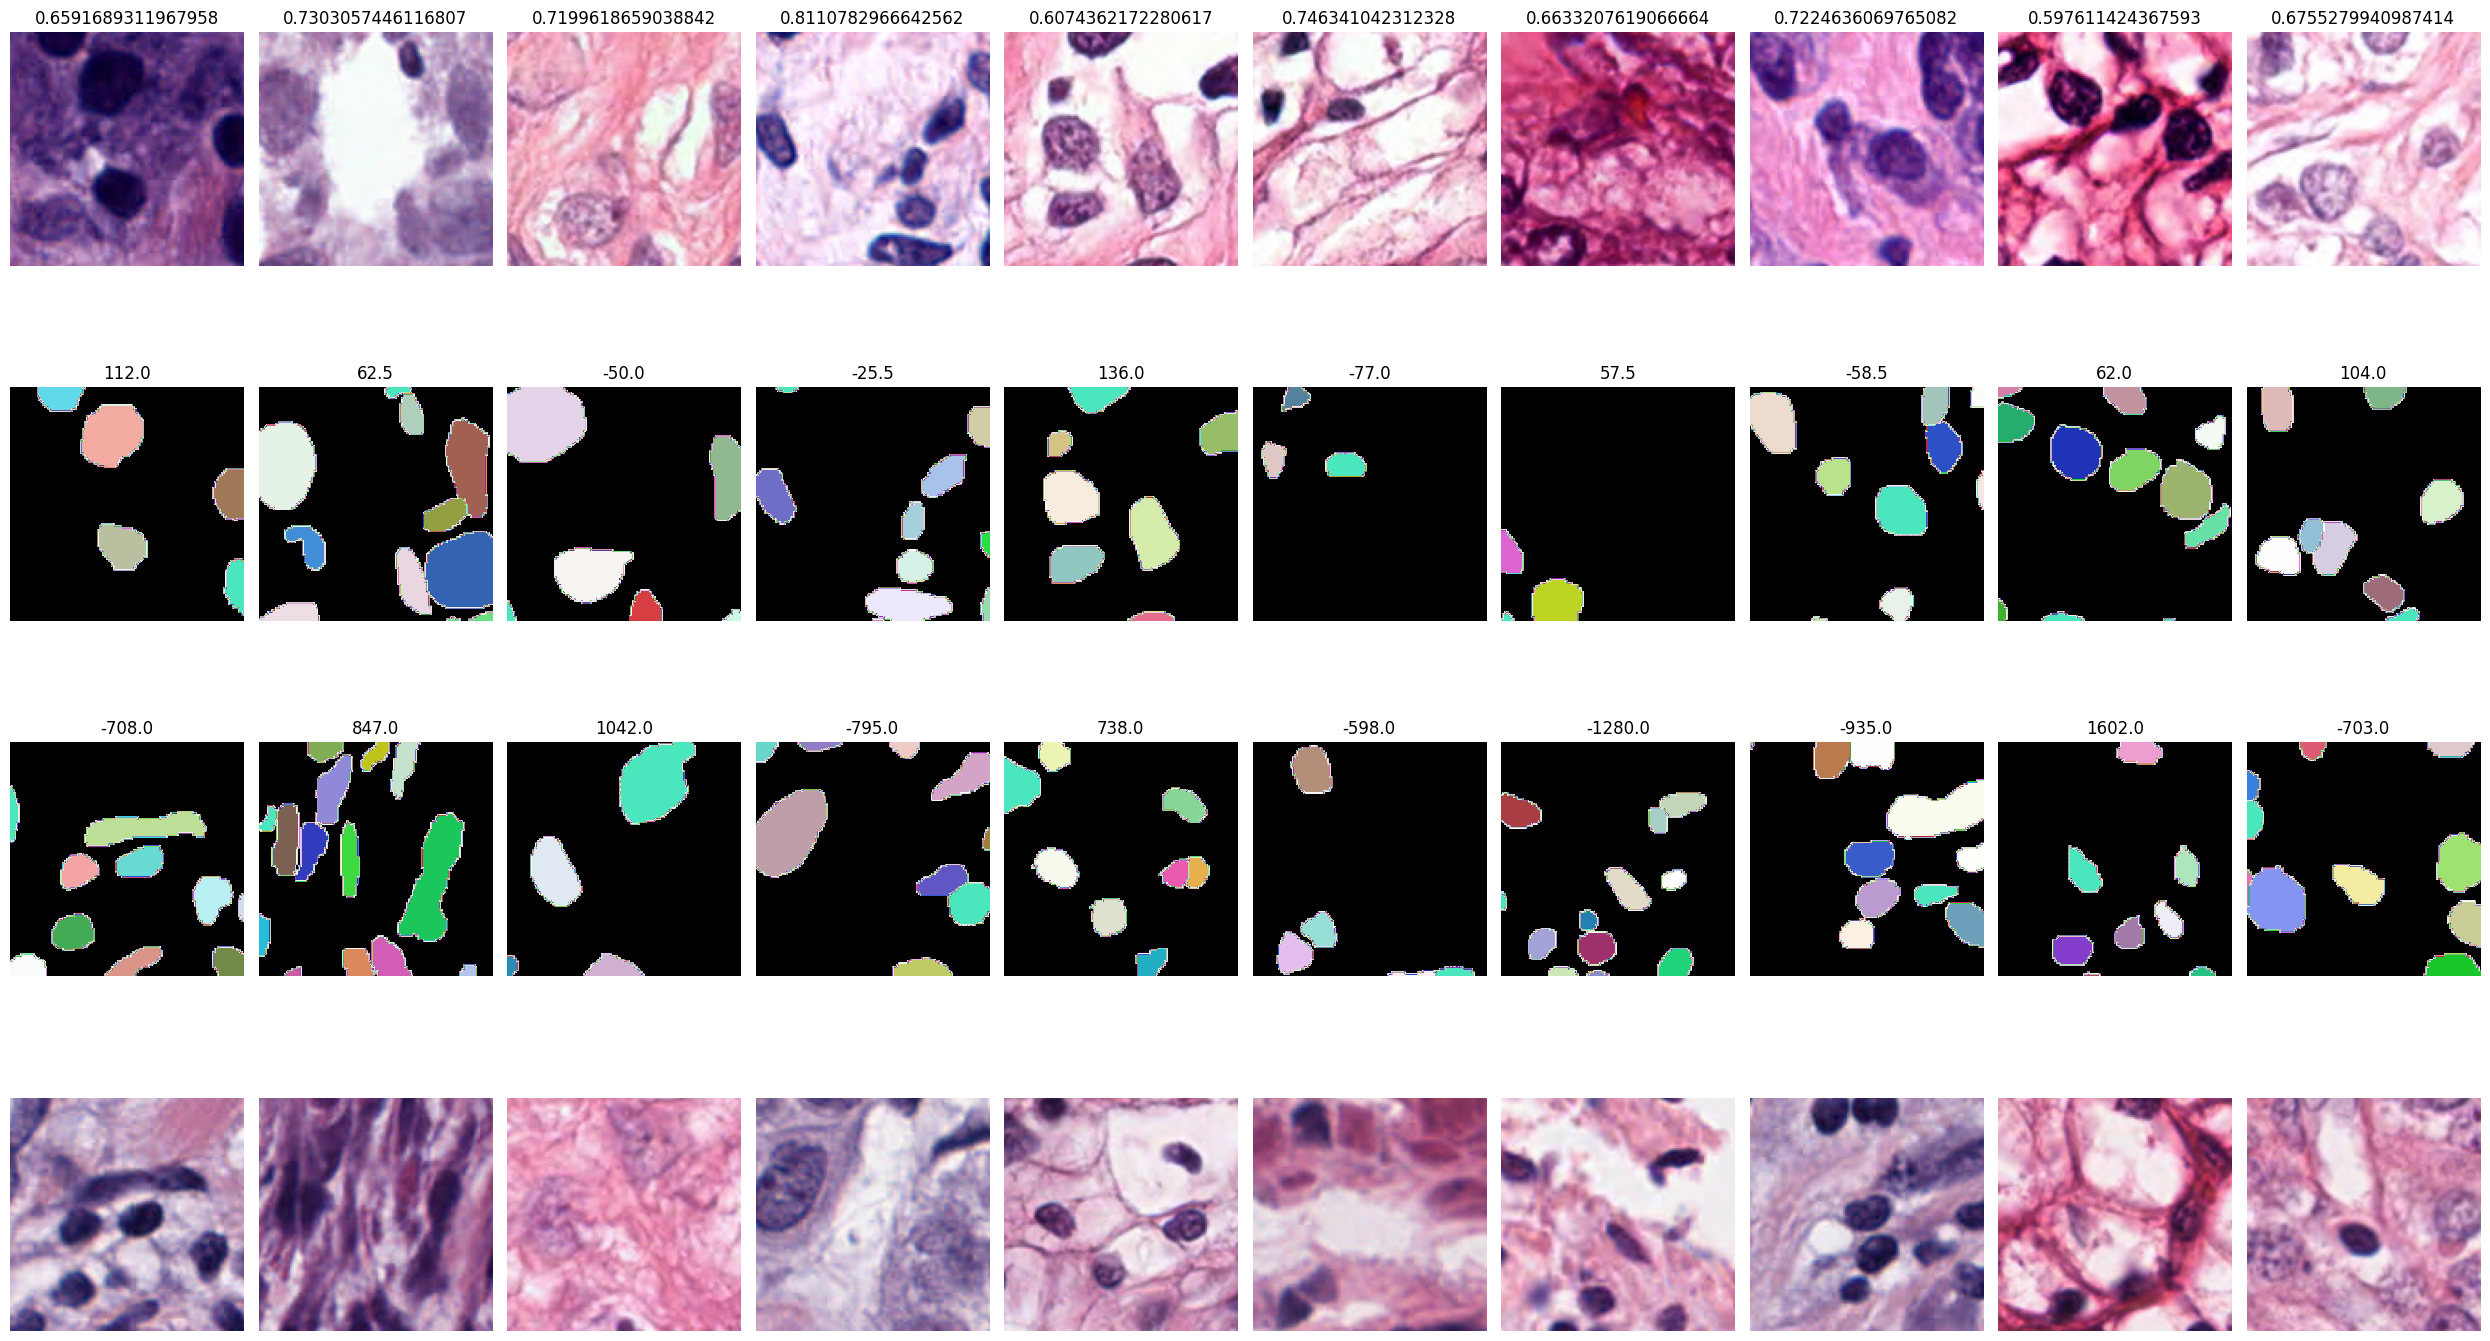

In [36]:
from matplotlib import pyplot as plt
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(42)
lbl_cmap = random_label_cmap()

n_img = 10
fig, ax = plt.subplots(4, n_img, figsize=(25, 15))

ind = np.random.choice(len(I_smd), n_img, replace=False, p=df_diff_scaled['prob']/np.sum(df_diff_scaled['prob']))

for i in range(n_img):
    y = ind[i]
    img = I_smd[y]
    ann = Y_sdm[y]
    pred = Y_app[y]
    app = I_app[y]
    # f1 = getattr(stats_sdm_best[y], 'f1')


    ax[0, i].imshow(img)
    ax[0, i].set_title(df_diff_scaled['prob'][y])
    ax[1, i].set_title(df_diff['med_area'][y])
    ax[1, i].imshow(ann, cmap=lbl_cmap)
    ax[2, i].set_title(df_diff['total_area'][y])
    ax[2, i].imshow(pred, cmap=lbl_cmap)
    ax[3, i].imshow(app)

    [axs.axis("off") for axs in ax.flatten()]

fig.tight_layout()

plt.show()

In [ ]:
from matplotlib import pyplot as plt
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
np.random.seed(42)
lbl_cmap = random_label_cmap()

n_img = 10
fig, ax = plt.subplots(4, n_img, figsize=(25, 15))

ind = np.random.choice(len(I_smd), n_img, replace=False)

for i in range(n_img):
    y = ind[i]
    img = I_smd[y]
    ann = Y_sdm[y]
    pred = Y_app[y]
    app = I_app[y]
    # f1 = getattr(stats_sdm_best[y], 'f1')


    ax[0, i].imshow(img)
    ax[1, i].set_title(df_diff['med'][y])
    ax[1, i].imshow(ann, cmap=lbl_cmap)
    ax[2, i].set_title(df_diff['area'][y])
    ax[2, i].imshow(pred, cmap=lbl_cmap)
    ax[3, i].imshow(app)

    [axs.axis("off") for axs in ax.flatten()]

fig.tight_layout()

plt.show()